# Data Analyzer

In [2]:
import os

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
import pandas as pd

In [36]:
import math

In [40]:
def calculate_Gflops(df):
    # GFLOPS = gigaflops per second = 1e-9 * 2*n^3 / time_in_secs
    #num_multiplies = (math.ceil((60000/df['Matrix_Size'])) * 5)
    num_epochs = 5
    num_training_examples = 60000
    df['GFLOPS'] = 10**-9 * 2*df['Matrix_Size']**3 * ((num_training_examples/df['Matrix_Size']) * num_epochs) / df['Layer_2_matmul_time']
    return df

In [38]:
def convert_us_to_seconds(df, rows):
    for row in rows: 
        df[row] = df[row] * 10**-6
    
    return df

In [44]:
onet_df = pd.read_csv('oneThreadTime.csv')

In [45]:
onet_df = convert_us_to_seconds(onet_df, ['Layer_2_matmul_time', 'Total_fastmm_time', 'Total_time'])

In [46]:
onet_df = calculate_Gflops(onet_df)

In [47]:
onet_df.head()

,Algorithm,Matrix_Size,Layer_2_matmul_time,Total_fastmm_time,Total_time,GFLOPS
0,dgemm,512,5.204562,56.020914,102.602407,30.220872
1,bini322,512,6.254049,65.692988,111.722769,25.149531
2,schonhage333,512,6.552512,68.468198,114.879527,24.003985
3,smirnov224,512,5.707803,61.161703,106.553489,27.556382
4,smirnov225,512,6.086669,65.499683,110.828567,25.841129


In [48]:
manyt_df = pd.read_csv('all_threads_time.csv')

In [49]:
manyt_df = convert_us_to_seconds(manyt_df, ['Layer_2_matmul_time', 'Total_fastmm_time'])

In [50]:
manyt_df = calculate_Gflops(manyt_df)

In [51]:
manyt_df.head()

,Algorithm,Matrix_Size,Layer_2_matmul_time,Total_fastmm_time,Total_time,GFLOPS
0,dgemm,512,4.127403,62.979546,48.312985,38.107840
1,bini322,512,28.838915,383.786572,196.926699,5.453964
2,schonhage333,512,29.138648,482.035273,239.686213,5.397862
3,smirnov224,512,32.338457,411.991258,203.177126,4.863757
4,smirnov225,512,27.344466,414.582551,209.891835,5.752038


In [36]:
# fastest algorithm at each size
def fastest_algo(df):
    matrix_sizes = [512, 1024, 2048, 4096, 8192]
    rows = []
    for size in matrix_sizes: 
        time = df[df['Matrix_Size'] == size]['Total_fastmm_time'].min()
        algo = df[df['Total_fastmm_time'] == time]['Algorithm'].iloc[0]
        if algo == 'dgemm':
            dgemm_speed_up = 'N/A'
        else:
            dgemm_time = df[(df['Matrix_Size'] == size) & (df['Algorithm'] == 'dgemm')]['Total_fastmm_time'].iloc[0]
            dgemm_speed_up = dgemm_time/ time
            
        rows.append({'Size':size, 'Fastest Algorithm': algo, 'dgemm speed up':dgemm_speed_up})
    
    print(pd.DataFrame(rows))

In [37]:
# fastest one thread algorithms
fastest_algo(onet_df)

   Size Fastest Algorithm dgemm speed up
0   512             dgemm            N/A
1  1024        smirnov442       1.083664
2  2048        smirnov444       1.205450
3  4096        smirnov444       1.266563
4  8192        smirnov444       1.271525


In [49]:
# fastest all thread algorithms
fastest_algo(manyt_df)

   Size Fastest Algorithm dgemm speed up
0   512             dgemm            N/A
1  1024             dgemm            N/A
2  2048             dgemm            N/A
3  4096             dgemm            N/A
4  8192             dgemm            N/A


In [6]:
def parallel_speedup(one_thread_df, all_thread_df, algorithm):
    matrix_sizes = [512, 1024, 2048, 4096, 8192]
    one_thread_times = []
    all_thread_times = []
    
    for size in matrix_sizes:
        one_thread_time = one_thread_df[(one_thread_df['Matrix_Size'] == size) & (one_thread_df['Algorithm'] == algorithm)]['Total_fastmm_time'].iloc[0]
        all_thread_time = all_thread_df[(all_thread_df['Matrix_Size'] == size) & (all_thread_df['Algorithm'] == algorithm)]['Total_fastmm_time'].iloc[0]
        print(f'Size: {size},      Parallel speed up: {one_thread_time/all_thread_time}')
    
    
    

In [58]:
parallel_speedup(onet_df, manyt_df, 'dgemm')

Size: 512,      Parallel speed up: 0.8895096509232062
Size: 1024,      Parallel speed up: 1.7410018804430902
Size: 2048,      Parallel speed up: 2.98003881517668
Size: 4096,      Parallel speed up: 5.23123062708694
Size: 8192,      Parallel speed up: 6.059563108929665


In [59]:
parallel_speedup(onet_df, manyt_df, 'smirnov444')

Size: 512,      Parallel speed up: 0.14480046683170275
Size: 1024,      Parallel speed up: 0.5901708680087903
Size: 2048,      Parallel speed up: 1.2915158700486564
Size: 4096,      Parallel speed up: 2.2349725251354466
Size: 8192,      Parallel speed up: 3.28177899458163


In [60]:
parallel_speedup(onet_df, manyt_df, 'smirnov442')

Size: 512,      Parallel speed up: 0.22903728815197325
Size: 1024,      Parallel speed up: 0.7644607586797217
Size: 2048,      Parallel speed up: 1.775863251916115
Size: 4096,      Parallel speed up: 3.608243062125481
Size: 8192,      Parallel speed up: 4.799601541619025


In [7]:
parallel_speedup(onet_df, manyt_df, 'bini322')

Size: 512,      Parallel speed up: 0.17117062653137188
Size: 1024,      Parallel speed up: 0.5852405822920187
Size: 2048,      Parallel speed up: 1.2293388223529642
Size: 4096,      Parallel speed up: 3.1073803344748345
Size: 8192,      Parallel speed up: 4.069818362314777


In [33]:
def time_plotter(algorithm, df):
    dgemm_times = []
    algorithm_times = []
    
    matrix_sizes = [512, 1024, 2048, 4096, 8192]
    for size in matrix_sizes:
        dgemm_times.append(df[(df['Matrix_Size'] == size) & (df['Algorithm'] == 'dgemm')]['GFLOPS'].iloc[0])
        algorithm_times.append(df[(df['Matrix_Size'] == size) & (df['Algorithm'] == algorithm)]['GFLOPS'].iloc[0])
    

    x = np.arange(len(matrix_sizes))
    width = 0.2

    plt.rcParams['figure.figsize'] = [15, 6]

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, dgemm_times, width, label='dgemm')
    rects2 = ax.bar(x + width/2, algorithm_times, width, label=algorithm)

    ax.set_ylabel('GFLOPS')
    ax.set_xlabel('Matrix size')
    ax.set_title(f'{algorithm} time vs dgemm time')
    ax.set_xticks(x)
    ax.set_xticklabels(matrix_sizes)
    ax.legend()

    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')


    autolabel(rects1)
    autolabel(rects2)

    fig.tight_layout()


    plt.show()

## Fastest One Thread Algorithms vs dgemm (classic matmul)

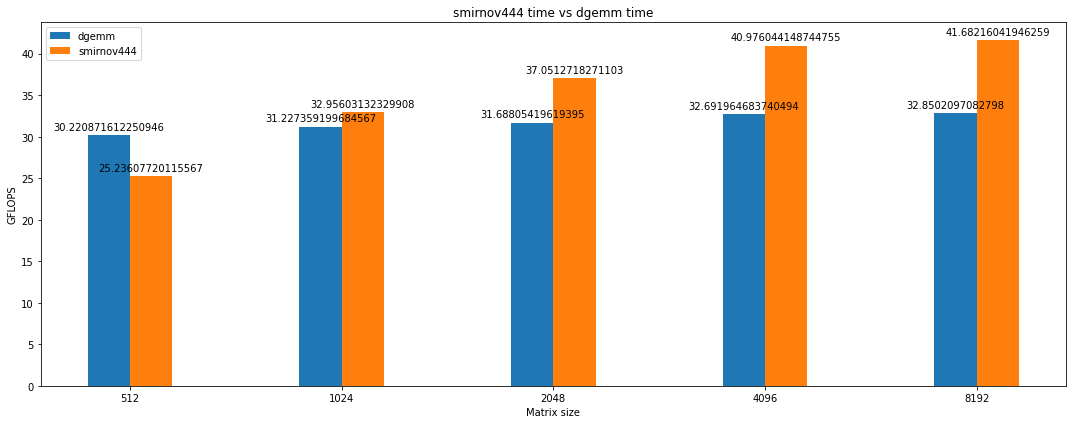

In [52]:
time_plotter(algorithm='smirnov444', df=onet_df)

The average epoch time goes down as the batch size gets larger because less multiplications are being done

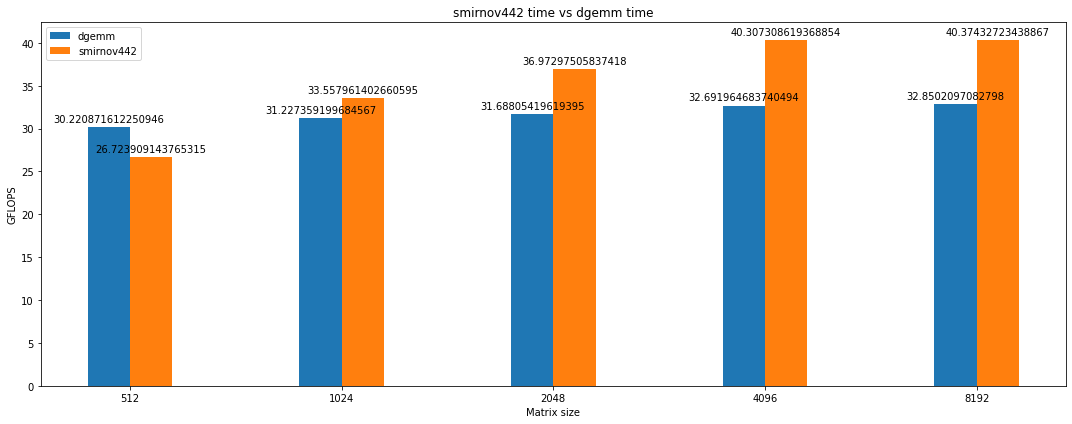

In [53]:
time_plotter(algorithm='smirnov442', df=onet_df)

## All Thread times

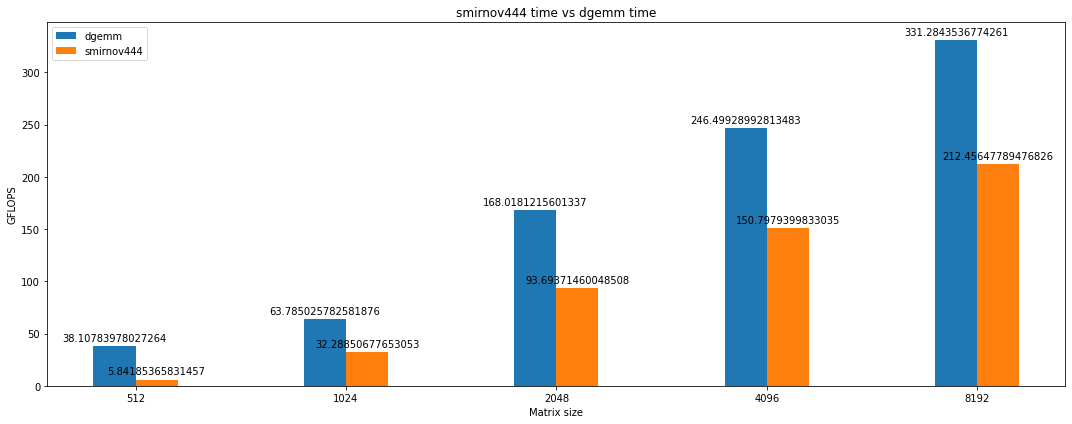

In [54]:
time_plotter(algorithm='smirnov444', df=manyt_df)

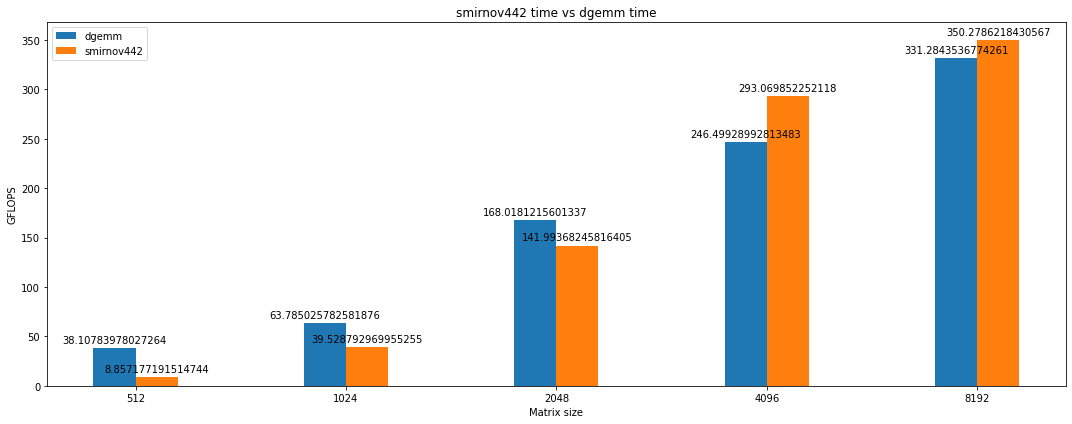

In [55]:
time_plotter(algorithm='smirnov442', df=manyt_df)